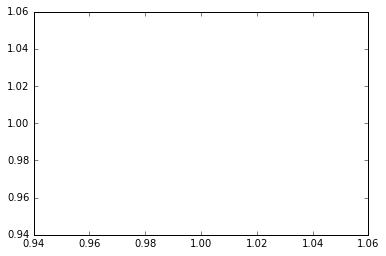

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(1,1)

In [2]:
import GPflow
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=4) # precision to print numpy array
import time
import cPickle as pickle


import AssignGPGibbsSingleLoop
import branch_kernParamGPflow as bk
import assigngp_dense 
import BranchingTree as bt

seed = 43

np.random.seed(seed=seed) # easy peasy reproducibeasy
tf.set_random_seed(seed)

(437, 2)
(437,)


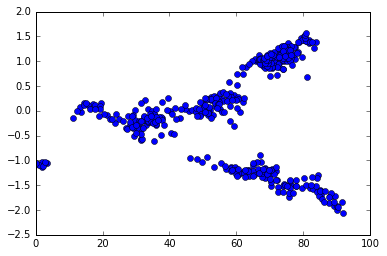

In [3]:
# From manifold load pseudotime, Y and labels
dictData = pickle.load( open( "data/guo_ssData.p", "rb" ) )
YFull = dictData['YGPLVM']
labels=dictData['labels']
ptFull = dictData['pt']

print YFull.shape
print ptFull.shape
plt.plot(ptFull, YFull[:,0],'bo')

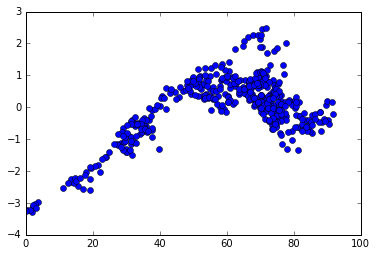

In [4]:
plt.plot(ptFull, YFull[:,1],'bo')

(219,)
(219, 1)
(437,)
(437, 2)


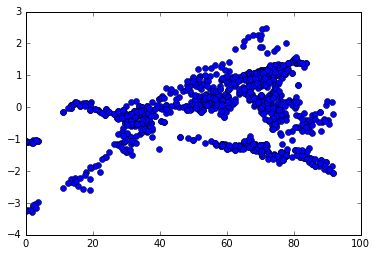

In [5]:
pt = ptFull[::2][:].copy()
Y = YFull[::2,0][:,None].copy()
plt.plot(pt, Y,'bo')
print pt.shape
print Y.shape

pt = ptFull[:].copy()
Y = YFull.copy()
plt.plot(pt, Y,'bo')
print pt.shape
print Y.shape

In [6]:
labels
# UNDONE should use the labels for validation!

Index([u'1', u'1', u'1', u'1', u'1', u'1', u'1', u'1', u'1', u'2',
       ...
       u'64 PE', u'64 PE', u'64 PE', u'64 EPI', u'64 PE', u'64 TE', u'64 TE',
       u'64 TE', u'64 TE', u'64 TE'],
      dtype='object', length=437)

In [7]:
# tree struct
tree = bt.BinaryBranchingTree(0,90,fDebug=False) # set to true to print debug messages
tree.add(None,1,10) # single branching point
(fm, _) = tree.GetFunctionBranchTensor()


# Initialise Kernel
BvaluesInit = np.ones((1,1)) # initial values

Kbranch = bk.BranchKernelParam(GPflow.kernels.Matern32(1), fm, BvInitial=BvaluesInit) + GPflow.kernels.White(1)
#varianceLik = 0.01 # likelihood variance
#Kbranch.white.variance = 0.001 # controls the discontinuity magnitude, the gap at the branching point
#Kbranch.branchkernelparam.kern.lengthscales = 40
#Kbranch.branchkernelparam.kern.variance = 0.2
#Kbranch.branchkernelparam.Bv = BvaluesInit

# Alternative initialisation - based on fitting GP early on data
varianceLik=0.0036
Kbranch.white.variance = 0.0421
Kbranch.branchkernelparam.kern.variance = 1.232
Kbranch.branchkernelparam.kern.lengthscales = 65
Kbranch.branchkernelparam.kern.variance = 0.0012 #  2.3158


print 'Branching kernel'
print Kbranch

# Initialise model
m = AssignGPGibbsSingleLoop.AssignGPGibbsFast(pt, Y, Kbranch)
m.likelihood.variance = varianceLik
m.kern.branchkernelparam.Bv = BvaluesInit
m.kern.branchkernelparam.Bv.fixed = True

m.CompileAssignmentProbability(fDebug=False,fMAP=True) # If hyperparameters are changed, this function should be called to reocmpute KChol

print m.XExpanded.shape
print len(m.indices)
#print XSampleGeneral

mV = assigngp_dense.AssignGP(pt, m.XExpanded, Y, Kbranch)
mV.likelihood.variance = varianceLik
mV._compile() # creates objective function

Branching kernel
unnamed.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 65.]
unnamed.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 0.0012]
unnamed.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
unnamed.white.\u001bvariance\u001b transform:+ve prior:None
[ 0.0421]
(1311, 2)
437
compiling tensorflow function...
done


In [8]:
D=Y.shape[1]
N = pt.size
print N

437


In [9]:
def plotPosterior(pt, Bv):
    l = np.min(pt)
    u = np.max(pt)
    D = mV.Y.shape
    f, ax = plt.subplots(D,1,figsize=figsizeIn, sharex=True, sharey=True)
    
    for f in range(1, 4):
        #fig = plt.figure(figsize=(12,8))
        if(f==1):
            ttest = np.linspace(l, Bv, 100)[:,None] # root
        else:
            ttest = np.linspace(Bv, u, 100)[:,None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu)
        col = mean.get_color()
        plt.plot(ttest, mu + 2*np.sqrt(var), '--', color=col)
        plt.plot(ttest, mu - 2*np.sqrt(var), '--', color=col)
# plotPosterior(pt, b)


In [ ]:
def PlotSample(D,X,M,samples,B=None,lw=3.,fs=10,figsizeIn=(12,16),title=None, mV=None):  
    f, ax = plt.subplots(D,1,figsize=figsizeIn, sharex=True, sharey=True)
    nb=len(B) # number of branch points 
    for d in range(D):
        for i in range(1,M+1):
            t=X[ X[:,1]==i,0]
            y=samples[X[:,1]==i,d]
            if(t.size == 0):
                continue 
            if(D != 1):
                p = ax.flatten()[d]
            else:
                p = ax

            p.plot(t, y, '.',label=i, markersize=2*lw)
            p.text(t[t.size/2],y[t.size/2], str(i), fontsize=fs)
        # Add vertical lines for branch points
        if(title is not None):
            p.set_title(title + ' Dim=' + str(d), fontsize=fs)

        if(B is not None):
            v=p.axis()
            for i in range(nb):     
                p.plot([B[i],B[i]],v[-2:],'--r')
        if(mV is not None):
            assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)

            pt = mV.t
            l = np.min(pt)
            u = np.max(pt)
            for f in range(1, 4):
                if(f==1):
                    ttest = np.linspace(l, B.flatten(), 100)[:,None] # root
                else:
                    ttest = np.linspace(B.flatten(), u, 100)[:,None]
                Xtest = np.hstack((ttest, ttest*0+f))
                mu, var = mV.predict_f(Xtest)
                assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
                assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
                mean, = p.plot(ttest, mu[:,d], linewidth=lw)
                col = mean.get_color()
                #print 'd='+str(d)+ ' f='+str(f) + '================'
                # variance is common for all outputs!
                p.plot(ttest.flatten(), mu[:,d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
                p.plot(ttest, mu[:,d] - 2*np.sqrt(var.flatten()), '--', color=col,linewidth=lw)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, mV=mV, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,-chainState[-1],VBbound))

In [ ]:
Bpossible = np.array([10., 25., 45.,  60.]) 
#Bpossible = np.linspace(2,70,22)
logLike = []

logVBBound = []

start_time = time.time()
fOptimizeHyperparameters = True

for b in Bpossible:
    Bcrap = np.atleast_2d(b) # crappy branch point
     
    # reinitialise hyperparameters
    Kbranch.white.variance = 0.0421
    Kbranch.branchkernelparam.kern.lengthscales = 65 # 20 + (90. - b) / 2. # 65
    Kbranch.branchkernelparam.kern.variance = 0.0009 #0.0012 #  2.3158
    m.likelihood.variance = varianceLik

    if(fOptimizeHyperparameters):
        # should recompute Kernel everytime we update kernel hyperparameters
        m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

    # set branching point
    m.kern.branchkernelparam.Bv = Bcrap 

    print '============> B=' + str(m.kern.branchkernelparam.Bv._array.flatten())
    
    # Random assignment for given branch point
    randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(pt,Bcrap,m.indices)
    #print m.XExpanded[randomAssignment,1]

    numMCMCsteps = 10
    chainState = np.ones(10)
    print m
    (chainState, bestAssignment,assignmentHistory,condProbs) = m.InferenceGibbsMAP(fReturnAssignmentHistory=True,fDebug=False,\
                                                                 maximumNumberOfSteps=numMCMCsteps,\
                                                                 startingAssignment=list(randomAssignment))
        
    #bk.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=3.,fs=30, figsizeIn=(10,7),title='before Optim: MAP result B='+str(b) + ' lik=' + str(chainState[-1]))


    if(fOptimizeHyperparameters):
        try:
            m.OptimizeK(list(bestAssignment))
        except:
            print 'Exception most probably due to inversion error - skipping'
            logLike.append(np.nan)
            logVBBound.append(np.nan)
            continue 
        
        #m.kern.branchkernelparam.kern.variance.fixed = False 
        #m.kern.white.variance.fixed = False

        # dont reestimate labels due to bad local minima
        #(chainState, bestAssignment) = m.InferenceGibbsMAP(fDebug=False,maximumNumberOfSteps=numMCMCsteps,\
        #                                                             startingAssignment=list(bestAssignment))

        print m
        
    # TODO: extend to multiple branch points
    logLike.append(chainState[-1])
    
    # Variational bound - no recomputing
    mV.kern.branchkernelparam.Bv = Bcrap
    print 'Variational kernel branch value ' + str(mV.kern.branchkernelparam.Bv._array.flatten())
    # Set state for assignments
    phiSet = mV.InitialisePhi(m.indices, bestAssignment, b, condProbs, fSoftAssignment = True)
    # Could also optimize!
    try:
        VBbound = mV._objective(mV.get_free_state())[0] # this is -log of bound
    except:
            print 'VB Exception most probably due to inversion error - skipping'
            logLike.append(np.nan)
            logVBBound.append(np.nan)
            continue 
            
    logVBBound.append(VBbound)
    
    #bk.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=3.,fs=30, figsizeIn=(10,7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,-chainState[-1],VBbound))
    #plotPosterior(pt, b)
    PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, mV=mV, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,-chainState[-1],VBbound))
    
    print 'B=' + str(b) + '. MAP lik=%.2f, VB bound=%.2f'%(chainState[-1],VBbound)    

elapsed_time = time.time() - start_time
print 'Elapsed times %.1f minutes.'%(elapsed_time/60.)

In [ ]:
nlogL = -np.array(logLike)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logLike)],nlogL, '-ob')
plt.title('-logpdf (b)')
v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')
print 'ML estimated B ' + str(minB) + ' with likelihood ' + str(logLike[iMin])

In [ ]:
nlogL = np.array(logVBBound)
iMin = np.argmin(nlogL)
plt.plot(Bpossible[:len(logVBBound)],nlogL, '-ob')
plt.title('-log marginal (vb) (b)')

v=plt.axis()
minB = Bpossible[iMin]
plt.plot([minB,minB],v[-2:],'--b')

print 'VB estimated B ' + str(minB) + ' with marginal likelihood ' + str(logVBBound[iMin])

In [ ]:
len(logVBBound)

In [ ]:
Bpossible[:len(logVBBound)]

In [ ]:
p = m.kern.branchkernelparam.Bv
p._array.flatten()

In [ ]:
for i in range(10):
    try:
        if i == 3:
            raise NameError('HiThere')
    except:
        print 'Exception most probably due to inversion error - skipping'
        logLike.append(np.nan)
        logVBBound.append(np.nan)
        continue 
    finally:
        pass
    print i

In [ ]:
mV

In [ ]:
m.KChol.shape